## Network analysis

Calculate and plot network metrics for the graphs created in the last step as well as some of the Google COVID-19 Mobility Report data for the relevant time periods.

In [1]:
# to allow relative imports
import os
import sys
from sys_path_util import append_sys_path
append_sys_path()

import matplotlib
from matplotlib import pyplot as plt
import seaborn
from functools import partial

GRAPHICS = 'graphics'

if not os.path.isdir(GRAPHICS):
    os.mkdir(GRAPHICS)

from lib.experiments.utils.data_repo_api import DataRepoAPI

Read pickled data created in previous steps.

#### Mobility data

In [2]:
NETWORK_DATA = 'network-data'

demographics = DataRepoAPI.get_pickle_file(NETWORK_DATA + '/demographics.pkl')

comb_counts_pre = DataRepoAPI.get_pickle_file(NETWORK_DATA + '/comb_counts_pre.pkl')
comb_counts_post = DataRepoAPI.get_pickle_file(NETWORK_DATA + '/comb_counts_post.pkl')

trip_counts_pre = DataRepoAPI.get_pickle_file(NETWORK_DATA + '/trip_counts_pre.pkl')
trip_counts_post = DataRepoAPI.get_pickle_file(NETWORK_DATA + '/trip_counts_post.pkl')

google_mobility_agg = DataRepoAPI.get_pickle_file(NETWORK_DATA + '/google_mobility_agg.pkl')

#### Network metrics

In [3]:
NETWORK_METRICS_PATH = 'network-metrics'

# load data from repo

mob_pre = DataRepoAPI.get_json_file(NETWORK_METRICS_PATH + '/mobility_pre.json')
mob_post = DataRepoAPI.get_json_file(NETWORK_METRICS_PATH + '/mobility_post.json')

plc_pre = DataRepoAPI.get_json_file(NETWORK_METRICS_PATH + '/plc_pre.json')
plc_post = DataRepoAPI.get_json_file(NETWORK_METRICS_PATH + '/plc_post.json')

dist_pre = DataRepoAPI.get_json_file(NETWORK_METRICS_PATH + '/distanced_pre.json')
dist_post = DataRepoAPI.get_json_file(NETWORK_METRICS_PATH + '/distanced_post.json')

In [5]:
# some utility functions to extract the experiment results

def flatten(list_of_lists):
    return [i for j in list_of_lists for i in j]

def unnest_results(data, key):
    results = data['resultsets']['epyc.resultset.default']['results']
    nested = [x['results'][key] for x in results]
    
    if len(nested) == 0 or not isinstance(nested[0], list):
        return nested
    
    return flatten(nested)


unnest_densities = partial(unnest_results, key='densities')
unnest_degrees = partial(unnest_results, key='degrees')
unnest_cluster_coeffs = partial(unnest_results, key='cluster_coeffs')

In [8]:
# save all results to dictionaries

def make_metric_dict(res_mapping, unnest_func):
    dic = {}
    for i, j in res_mapping:
        dic[i] = unnest_func(j)
    return dic

# map results to name

pre_res = [
    ('Mobility', mob_pre), 
    ('PLC', plc_pre), 
    ('Distanced', dist_pre)
]


post_res = [
    ('Mobility', mob_post), 
    ('PLC', plc_post), 
    ('Distanced', dist_post)
]

# densities
density_dict_pre = make_metric_dict(pre_res, unnest_densities)
density_dict_post = make_metric_dict(post_res, unnest_densities)

# degrees
degrees_dict_pre = make_metric_dict(pre_res, unnest_degrees)
degrees_dict_post = make_metric_dict(post_res, unnest_degrees)

# cluster_coeffs
clustering_dict_pre = make_metric_dict(pre_res, unnest_cluster_coeffs)
clustering_dict_post = make_metric_dict(post_res, unnest_cluster_coeffs)

# shortest paths (get from repo)
sp_dict_pre = {
    'Mobility': DataRepoAPI.get_pickle_file(NETWORK_METRICS_PATH + '/sp_mng_pre.pkl'),
    'PLC': DataRepoAPI.get_pickle_file(NETWORK_METRICS_PATH + '/sp_plc_pre.pkl'),
    'Distanced': DataRepoAPI.get_pickle_file(NETWORK_METRICS_PATH + '/sp_dist_pre.pkl'),
}

sp_dict_post = {
    'Mobility': DataRepoAPI.get_pickle_file(NETWORK_METRICS_PATH + '/sp_mng_post.pkl'),
    'PLC': DataRepoAPI.get_pickle_file(NETWORK_METRICS_PATH + '/sp_plc_post.pkl'),
    'Distanced': DataRepoAPI.get_pickle_file(NETWORK_METRICS_PATH + '/sp_dist_post.pkl'),
}


### Mobility Visualisations

Define helper functions for plotting.

In [11]:
# set the colors of pairs of boxplots to red and blue.
def set_alternating_boxplot_colors(bp):
    
    if len(bp['medians']) >= 2:
        bp['medians'][0].set_color('firebrick')
        bp['medians'][1].set_color('steelblue')
    
    if len(bp['means']) >= 2:
        bp['means'][0].set_markerfacecolor('firebrick')
        bp['means'][1].set_markerfacecolor('steelblue')
    
    if len(bp['boxes']) >= 2:
        bp['boxes'][0].set_color('firebrick')
        bp['boxes'][1].set_color('steelblue')
    
    if len(bp['caps']) >= 4:
        bp['caps'][0].set_color('firebrick')
        bp['caps'][1].set_color('firebrick')
        bp['caps'][2].set_color('steelblue')
        bp['caps'][3].set_color('steelblue')

    if len(bp['whiskers']) >= 4:
        bp['whiskers'][0].set_color('firebrick')
        bp['whiskers'][1].set_color('firebrick')
        bp['whiskers'][2].set_color('steelblue')
        bp['whiskers'][3].set_color('steelblue')


def set_boxplot_color(bp, color):
    
    for cat in bp:
        for i in range(len(bp[cat])):
            bp[cat][i].set_color(color)
            try:
                bp[cat][i].set_markerfacecolor(color)
            except AttributeError:
                pass

Visualise the trip counts of the Patterns data and data from the Google COVID-19 Mobility Report.

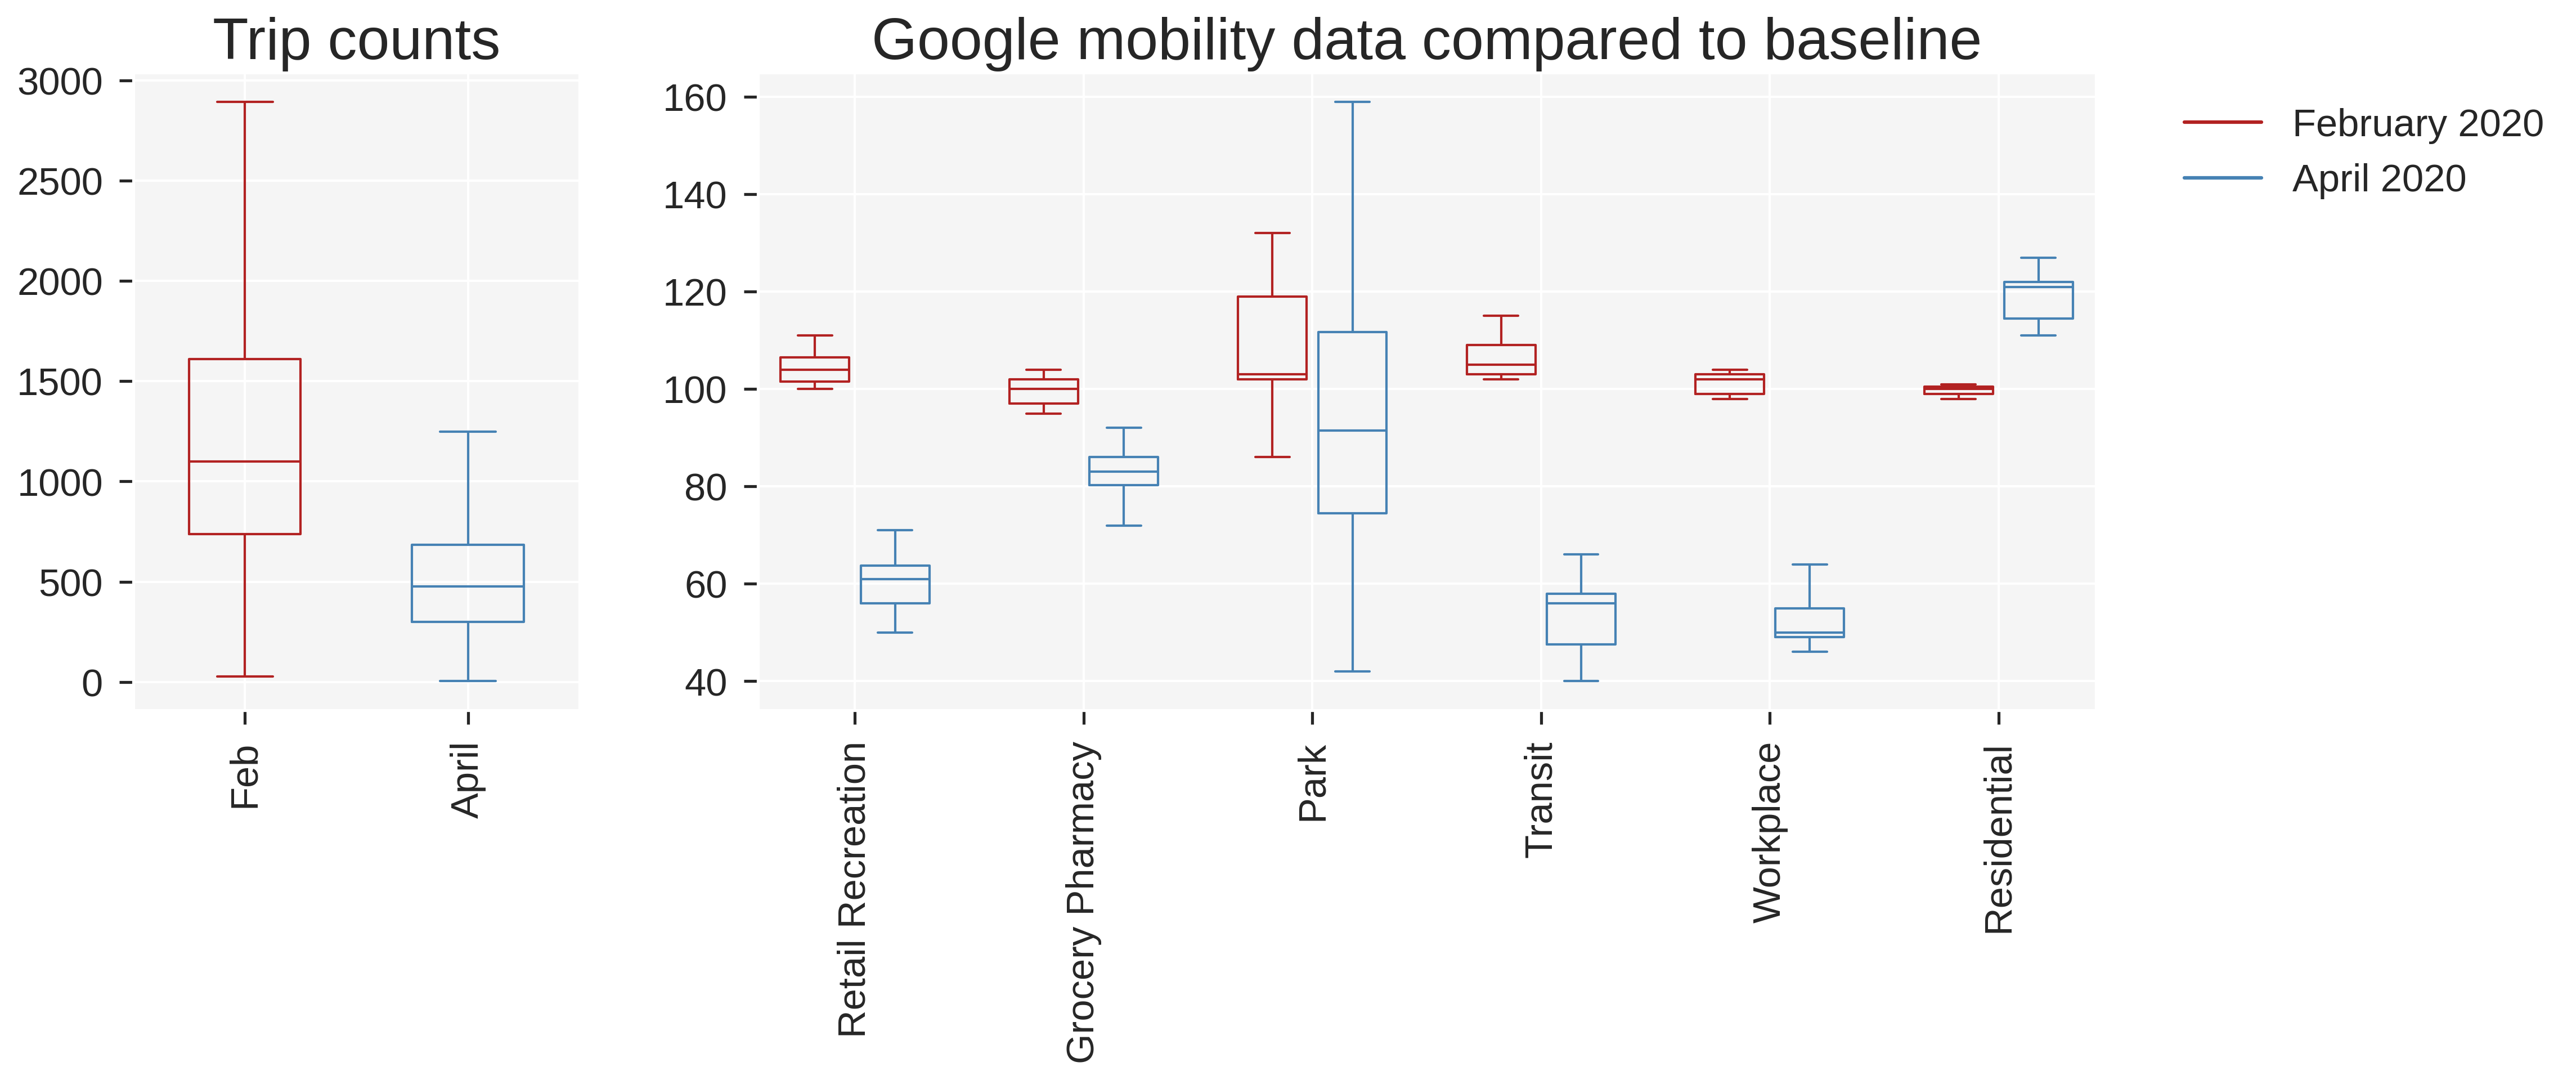

In [12]:
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.dpi'] = 300
seaborn.set_context('notebook', font_scale=1.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), facecolor='w', gridspec_kw={'width_ratios': [1, 3]})

# trip counts
data_trips = [list(trip_counts_pre.values()), list(trip_counts_post.values())]
bp = ax1.boxplot(data_trips, showfliers=False, widths=0.5)
set_alternating_boxplot_colors(bp)

ax1.set_facecolor('#F5F5F5')
ax1.set_title('Trip counts', fontsize=25)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Feb', 'April'], rotation=90)

# google
categories = [' '.join([w.capitalize() for w in x.split('_')]) 
              for x in google_mobility_agg[2].keys()]

c = 1
for k in google_mobility_agg[2].keys():
    data = [google_mobility_agg[2][k], google_mobility_agg[4][k]]
    bp = ax2.boxplot(data, positions = [c+0.15, c+0.85], widths=0.6, showfliers=False)
    set_alternating_boxplot_colors(bp)
    
    c += 2

ax2.set_title('Google mobility data compared to baseline', fontsize=25)
ax2.set_xticks([1.5 + i*2 for i, _ in enumerate(categories)])
ax2.set_xticklabels(list(categories), rotation=90)
ax2.set_facecolor('#F5F5F5')

_ = plt.plot([], color='firebrick', label='February 2020', ls='-')
_ = plt.plot([], color='steelblue', label='April 2020')
_ = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.savefig(GRAPHICS + '/mobility-metrics.png', bbox_inches="tight")
plt.show()

Visualise network metrics for both graphs.

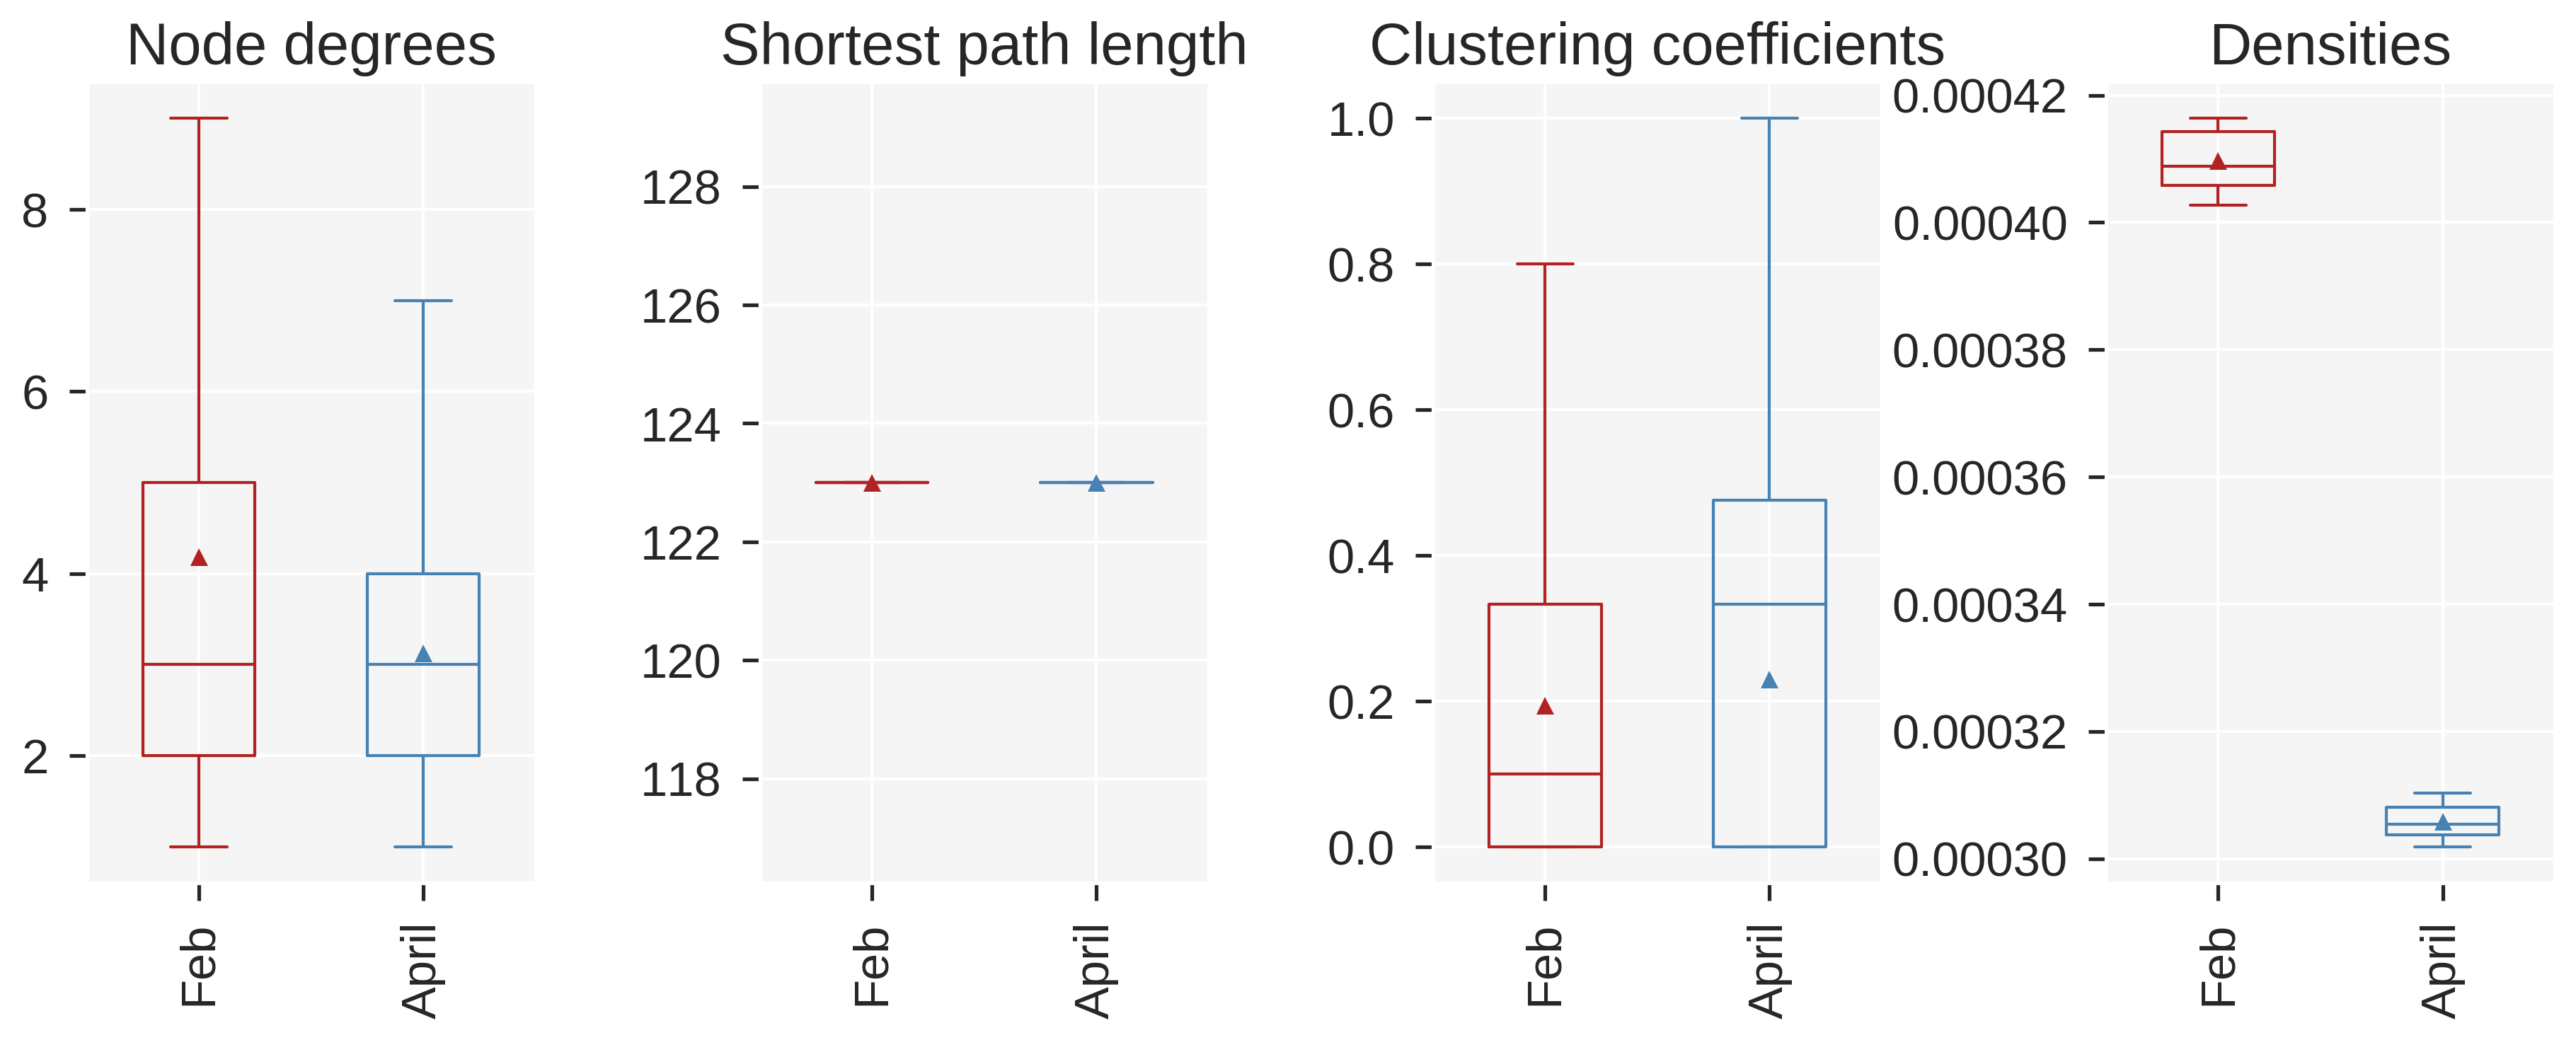

In [13]:
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.dpi'] = 300
seaborn.set_context('notebook', font_scale=1.5)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5), facecolor='w', 
                                         gridspec_kw={'width_ratios': [1, 1, 1, 1]})

# degrees
bp = ax1.boxplot([degrees_dict_pre['Mobility'], degrees_dict_post['Mobility']], 
                 showfliers=False, widths=0.5, showmeans=True)
set_alternating_boxplot_colors(bp)

ax1.set_facecolor('#F5F5F5')
ax1.set_title('Node degrees', fontsize=20)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Feb', 'April'], rotation=90)

# shortest path
bp = ax2.boxplot([sp_dict_pre['Mobility'], sp_dict_post['Mobility']], 
                 showfliers=False, widths=0.5, showmeans=True)
set_alternating_boxplot_colors(bp)

ax2.set_facecolor('#F5F5F5')
ax2.set_title('Shortest path length', fontsize=20)
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Feb', 'April'], rotation=90)

# clustering coefficient
bp = ax3.boxplot([clustering_dict_pre['Mobility'], clustering_dict_post['Mobility']], 
                 showfliers=False, widths=0.5, showmeans=True)
set_alternating_boxplot_colors(bp)

ax3.set_facecolor('#F5F5F5')
ax3.set_title('Clustering coefficients', fontsize=20)
ax3.set_xticks([1, 2])
ax3.set_xticklabels(['Feb', 'April'], rotation=90)

# density
bp = ax4.boxplot([density_dict_pre['Mobility'], density_dict_post['Mobility']], 
                 showfliers=False, widths=0.5, showmeans=True)
set_alternating_boxplot_colors(bp)

ax4.set_facecolor('#F5F5F5')
ax4.set_title('Densities', fontsize=20)
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Feb', 'April'], rotation=90)

plt.subplots_adjust(wspace=0.5)
plt.savefig(GRAPHICS + '/network-metrics.png', bbox_inches="tight")
plt.show()

### Network comparisons

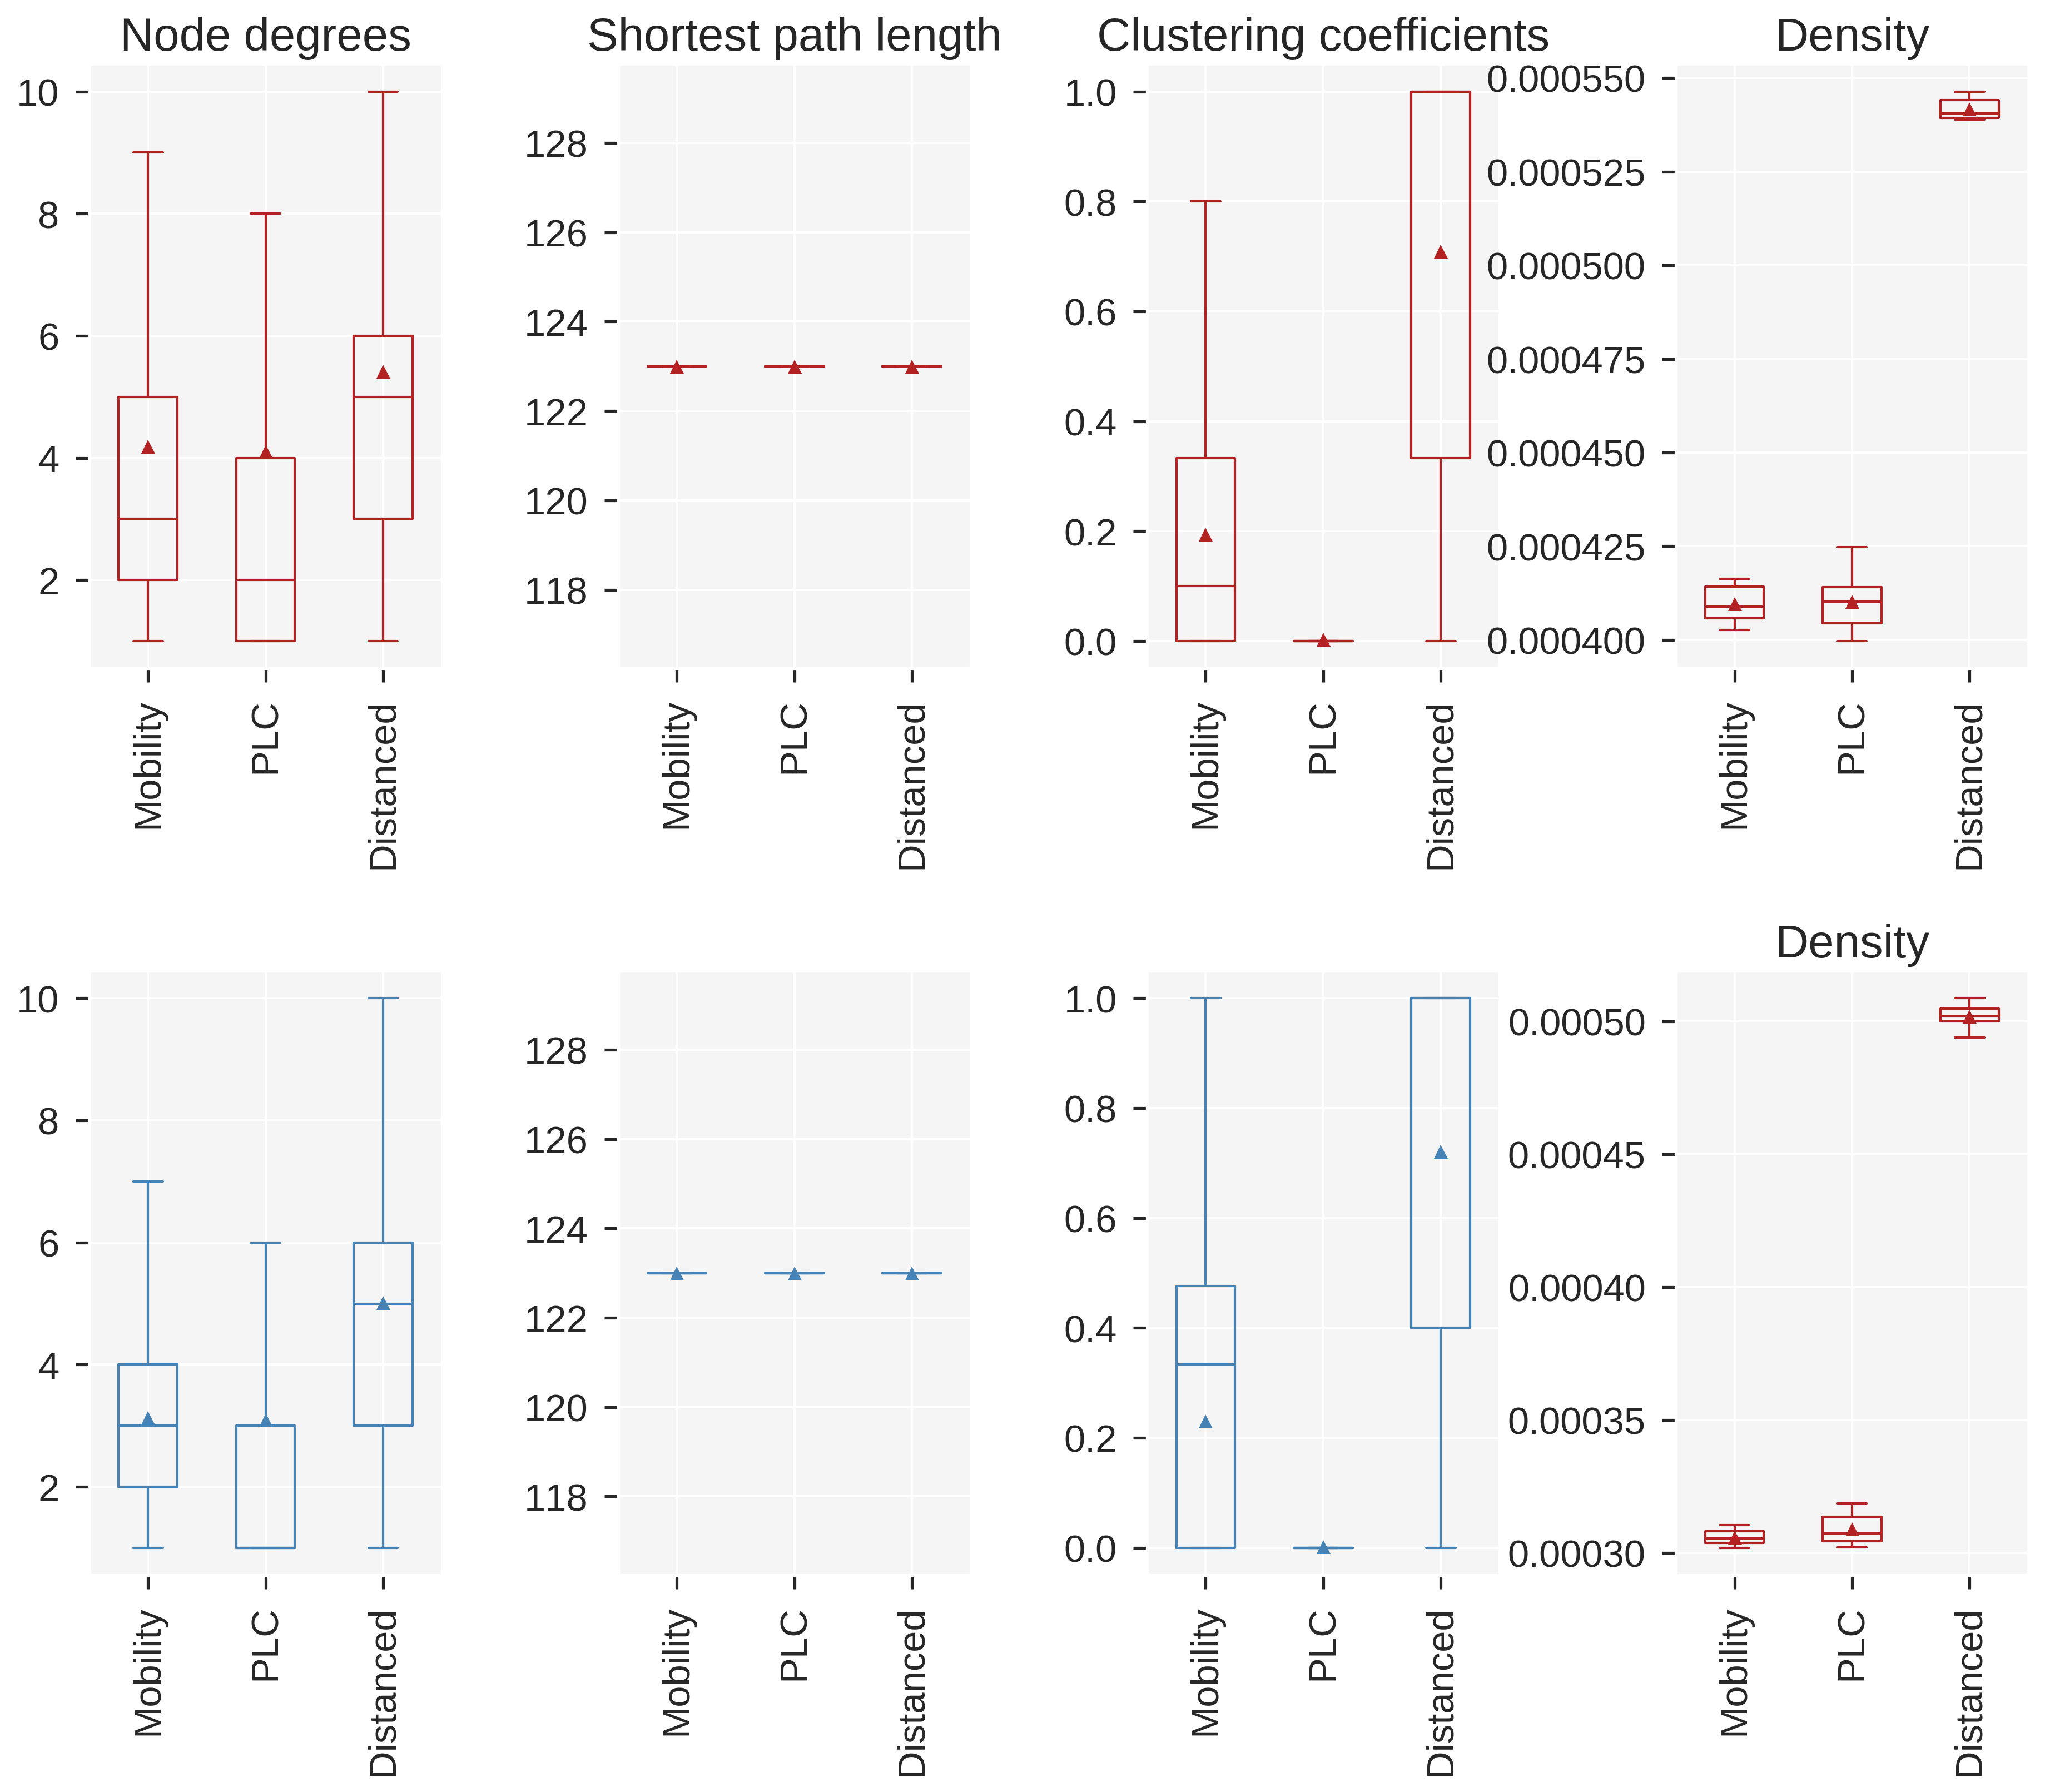

In [15]:
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.dpi'] = 300
seaborn.set_context('notebook', font_scale=1.5)

fig, (r1, r2) = plt.subplots(2, 4, figsize=(15, 12), facecolor='w', 
                             gridspec_kw={'width_ratios': [1, 1, 1, 1]})

ax1, ax2, ax3, ax4 = r1
ax5, ax6, ax7, ax8 = r2

# degrees
bp = ax1.boxplot(degrees_dict_pre.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'firebrick')

ax1.set_facecolor('#F5F5F5')
ax1.set_title('Node degrees', fontsize=20)
ax1.set_xticks([i+1 for i in range(len(degrees_dict_pre))])
ax1.set_xticklabels(degrees_dict_pre.keys(), rotation=90)

# shortest path
bp = ax2.boxplot(sp_dict_pre.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'firebrick')

ax2.set_facecolor('#F5F5F5')
ax2.set_title('Shortest path length', fontsize=20)
ax2.set_xticks([i+1 for i in range(len(sp_dict_pre))])
ax2.set_xticklabels(sp_dict_pre.keys(), rotation=90)

# clustering coefficient
bp = ax3.boxplot(clustering_dict_pre.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'firebrick')

ax3.set_facecolor('#F5F5F5')
ax3.set_title('Clustering coefficients', fontsize=20)
ax3.set_xticks([i+1 for i in range(len(clustering_dict_pre))])
ax3.set_xticklabels(clustering_dict_pre.keys(), rotation=90)

# density
bp = ax4.boxplot(density_dict_pre.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'firebrick')

ax4.set_facecolor('#F5F5F5')
ax4.set_title('Density', fontsize=20)
ax4.set_xticks([i+1 for i in range(len(density_dict_pre))])
ax4.set_xticklabels(density_dict_pre.keys(), rotation=90)

# fmt = lambda x, _: '{:.1f}'.format(x*10000) + 'E-4'
# ax4.yaxis.set_major_formatter(fmt)

### 2nd row

# degrees
bp = ax5.boxplot(degrees_dict_post.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'steelblue')

ax5.set_facecolor('#F5F5F5')
ax5.set_xticks([i+1 for i in range(len(degrees_dict_post))])
ax5.set_xticklabels(degrees_dict_post.keys(), rotation=90)

# shortest path
bp = ax6.boxplot(sp_dict_post.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'steelblue')

ax6.set_facecolor('#F5F5F5')
ax6.set_xticks([i+1 for i in range(len(sp_dict_post))])
ax6.set_xticklabels(sp_dict_post.keys(), rotation=90)

# clustering coefficient
_ = bp = ax7.boxplot(clustering_dict_post.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'steelblue')

ax7.set_facecolor('#F5F5F5')
ax7.set_xticks([i+1 for i in range(len(clustering_dict_post))])
ax7.set_xticklabels(clustering_dict_post.keys(), rotation=90)

# density
bp = ax8.boxplot(density_dict_post.values(), showfliers=False, widths=0.5, showmeans=True)
set_boxplot_color(bp, 'firebrick')

ax8.set_facecolor('#F5F5F5')
ax8.set_title('Density', fontsize=20)
ax8.set_xticks([i+1 for i in range(len(density_dict_post))])
ax8.set_xticklabels(density_dict_post.keys(), rotation=90)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(GRAPHICS + '/comparison-network-metrics.png', bbox_inches="tight")
plt.show()